# cUstom MODEL

In [1]:
import torch
from diffusers import DDPMScheduler, UNet1DModel
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

##########################################################################################
# Define time embedding
##########################################################################################
class SinPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = time / (10000**(2 * torch.arange(half_dim, device=device) / self.dim))
        embeddings = torch.cat((embeddings.sin().unsqueeze(1), embeddings.cos().unsqueeze(1)), dim=1).flatten()
        if self.dim % 2 == 1:
            embeddings = torch.cat((embeddings, (time / (10000**(2 * torch.tensor([half_dim], device=device) / self.dim))).sin())) 
        
        return embeddings

class SinPosEmbMatrix(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.time_emb = SinPosEmb(dim)

    def forward(self):
        x = torch.tensor([self.time_emb(i).tolist() for i in range(1000)], device=device)
        return x

##########################################################################################
# Define U-Network
##########################################################################################
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, structure, time_emb_method):
        super(DoubleConv, self).__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.time_emb_method = time_emb_method
        self.structure = structure
        
        if self.time_emb_method == "features_add":
            for i in range(len(self.structure)):
                if out_channels == self.structure[i]:
                    time_emb = SinPosEmbMatrix(64 // (2**i))
                    self.time_emb = time_emb()
        
        if self.time_emb_method == "channels_add":
            time_emb = SinPosEmbMatrix(256)
            self.time_emb = time_emb()
            self.linear = nn.Linear(256, out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.in_channels = in_channels
        
    def forward(self, x, t):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        if self.time_emb_method == "features_add":
            time = self.time_emb[t, :].unsqueeze(1)
            x = x + time
        elif self.time_emb_method == "channels_add":
            time = self.time_emb[t, :].unsqueeze(1)
            time = self.linear(time).squeeze(1).unsqueeze(-1)
            x = x + time

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, structure, time_emb_method):
        super(Down, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels, structure, time_emb_method)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x, t):
        x = self.pool(x)
        x = self.conv(x, t)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, structure, time_emb_method):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, structure, time_emb_method)
        
    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, (diff + 1) // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x, t)
        return x

class SmallUNet(nn.Module):
    def __init__(self, structure=[32, 64, 128], time_emb_method="features_add"):
        super(SmallUNet, self).__init__()
        self.structure = structure
        self.time_emb_method = time_emb_method
        assert self.time_emb_method in ["features_add", "channels_add"]

        self.convIn = DoubleConv(1, self.structure[0], self.structure, self.time_emb_method)
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for i in range(len(self.structure) - 1):
            self.downs.append(Down(self.structure[i], self.structure[i+1], self.structure, self.time_emb_method))
        for i in range(len(self.structure) - 1):
            self.ups.append(Up(self.structure[i+1], self.structure[i], self.structure, self.time_emb_method))

        self.convOut = nn.Conv1d(self.structure[0], 1, kernel_size=1)

    def forward(self, x, t):
        skips = []
        x = self.convIn(x, t)

        for i in range(len(self.structure)-1):
            skips.append(x)
            x = self.downs[i](x, t)
        
        for i in reversed(range(len(self.structure) - 1)):
            x = self.ups[i](x, skips[i], t)
        
        x = self.convOut(x)
        
        return x


Using cuda device


In [3]:

##########################################################################################
# Forward diffusion process and Dataset generation
##########################################################################################
def cos_betaAlpha_schedule(T=1000, s=0.005):
    x = torch.linspace(0, T, T+1)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.9999)
    alpha_bar = torch.cumprod(torch.tensor([1-betas[i] for i in range(len(betas))]), dim=0)
    return betas, alpha_bar

def extract(a, t, x_shape):
    b, *_ = t.shape
    a = a.to(t.device)
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def add_noise(X, t, alpha_bar):
    eps = torch.randn_like(X)
    mean = torch.sqrt(extract(alpha_bar.to(t.device), t, X.shape)) * X
    std = torch.sqrt(1 - extract(alpha_bar.to(t.device), t, X.shape))
    sample = mean + std * eps
    return sample, eps

def denoise(model, n, dim=64, T=1000):
    X = torch.randn(n, 1, dim, device=device)
    betas, alpha_bar = cos_betaAlpha_schedule()
    betas = betas.to(device)
    alpha_bar = alpha_bar.to(device)
    
    for tt in range(T - 1, -1, -1):
        t = torch.tensor([tt] * n, device=device)
        z = torch.randn(n, 1, dim, device=device) if tt > 1 else 0
        X_noise = model(X, t)
        t = t.long()
        
        alpha = 1.0 - betas[tt]
        alpha_bar_t = alpha_bar[tt]
        
        # Implement the denoising step
        X = (1 / torch.sqrt(alpha)) * (X - ((1 - alpha) / torch.sqrt(1 - alpha_bar_t)) * X_noise) + torch.sqrt(betas[tt]) * z
    
    return X

def denoise_conditional(model, n, dim=64, T=1000):
    X = torch.randn(n, 1, dim, device=device)
    betas, alpha_bar = cos_betaAlpha_schedule()
    betas = betas.to(device)
    alpha_bar = alpha_bar.to(device)
    
    for tt in range(T - 1, -1, -1):
        t = torch.tensor([tt] * n, device=device)
        z = torch.randn(n, 1, dim, device=device) if tt > 1 else 0
        X_noise = model(X, t)
        t = t.long()
        
        alpha = 1.0 - betas[tt]
        alpha_bar_t = alpha_bar[tt]
        
        prev_step = (1 / torch.sqrt(alpha)) * (X - ((1 - alpha) / torch.sqrt(1 - alpha_bar_t)) * X_noise)

        X = prev_step + torch.sqrt(betas[tt]) * z
    
    return X


import torch
from torch.distributions import MultivariateNormal

def conditional_noise_mvnorm(n, dim, device, sigma=1.0):
    Sigma = sigma**2 * torch.eye(dim, device=device)

    q = dim - 1  

    # Submatrices
    Sigma_11 = Sigma[:q, :q]                      
    Sigma_12 = Sigma[:q, q].unsqueeze(1)          
    Sigma_21 = Sigma[q, :q].unsqueeze(0)          
    Sigma_22 = Sigma[q, q].unsqueeze(0).unsqueeze(1)  

    mu1 = torch.zeros(q, device=device)
    mu2 = torch.tensor([0.0], device=device)  
    a = torch.tensor([0.0], device=device)

    mu_c = mu1 + Sigma_12 @ torch.linalg.solve(Sigma_22, (a - mu2))  
    Sigma_c = Sigma_11 - Sigma_12 @ torch.linalg.solve(Sigma_22, Sigma_21)  

    mvn = MultivariateNormal(loc=mu_c, covariance_matrix=Sigma_c)

    z_samples = mvn.sample((n,))  

    z_last = -z_samples.sum(dim=1, keepdim=True)  

    z_full = torch.cat([z_samples, z_last], dim=1).unsqueeze(1)  

    return z_full


In [30]:

class TrivialDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=64):  
        self.data = torch.ones(num_samples, seq_len)
        self.data[:, 32:] = 0
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {"X": self.data[idx]}

class SinDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=31):
        # Create a simple sine wave dataset
        self.data = []
        for _ in range(num_samples):
            freq = torch.rand(1).item() * 5 + 1
            t = torch.linspace(0, 2*math.pi, seq_len)
            phase = torch.rand(1).item() * 2 * math.pi
            signal = torch.sin(freq * t + phase)
            signal = (signal - signal.min()) / (signal.max() - signal.min()) * 2 - 1
            self.data.append(signal)
        
        self.data = torch.stack(self.data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {"X": self.data[idx]}

class BrownianBridgeDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=64, end_point=0.0):
        self.data = torch.zeros(num_samples, seq_len)
        times = torch.linspace(0, 1, seq_len)
        dt = 1.0 / (seq_len - 1)

        
        for i in range(num_samples):
            dW = torch.randn(seq_len - 1) * np.sqrt(dt)

            W = torch.cumsum(dW, 0)
            W = torch.cat([torch.tensor([0.0]), W])
            
            t = times
            bridge = W - t * W[-1] + t * end_point
            
            self.data[i] = bridge
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {"X": self.data[idx]}
  
class BrownianBridgeDataset0(Dataset):
    def __init__(self, num_samples=1000, seq_len=64, end_point=0.0):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.end_point = end_point
        self.data = self.sample_path_batch(self.num_samples, self.seq_len)
    
    def sample_path_batch(self, M, N):
        dt = 1.0 / (N - 1)
        dt_sqrt = np.sqrt(dt)
        B = np.empty((M, N), dtype=np.float32)
        B[:, 0] = 0
        for n in range(N - 2):
            t = n * dt
            xi = np.random.randn(M) * dt_sqrt
            B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
        B[:, -1] = self.end_point
        return torch.from_numpy(B)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return {"X": self.data[idx]}

In [ ]:

class BrownianBridgeDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=64, end_point=0.0):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.end_point = end_point
        self.data = self.sample_path_batch(self.num_samples, self.seq_len)
    
    def sample_path_batch(self, M, N):
        dt = 1.0 / (N - 1)
        dt_sqrt = np.sqrt(dt)
        B = np.empty((M, N), dtype=np.float32)
        B[:, 0] = 0
        for n in range(N - 2):
            t = n * dt
            xi = np.random.randn(M) * dt_sqrt
            B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
        B[:, -1] = self.end_point
        return torch.from_numpy(B)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return {"X": self.data[idx]}

In [39]:
##########################################################################################
# Train model
##########################################################################################
def train_model(model, dataset, dim=31, T=1000, batch_size=64, epochs=20):
    
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Loss function
    loss_fn = nn.MSELoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    # Get beta schedule
    _, alpha_bar = cos_betaAlpha_schedule(T=T)
    alpha_bar = alpha_bar.to(device)
    
    # For loss tracking
    losses = []
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0
        
        print(f"Epoch {epoch+1}/{epochs}")
        
        for i, data in enumerate(train_dataloader):
            b = data["X"].shape[0]
            # Sample random timesteps
            t = torch.randint(0, T, (b,), device=device).long()
            
            # Add noise to the clean images according to the timestep
            X_noisy, noise = add_noise(data["X"].to(device), t, alpha_bar)
            X_noisy = X_noisy.unsqueeze(1)  # Add channel dimension
            noise = noise.unsqueeze(1)      # Add channel dimension
            
            # Predict the noise
            optimizer.zero_grad()
            noise_pred = model(X_noisy, t)
            
            # Calculate loss
            loss = loss_fn(noise_pred, noise)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            # Update metrics
            epoch_loss += loss.item()
            batch_count += 1
            
            #if (i+1) % 1000 == 0:
            #    print(f"  Batch {i+1}/{len(train_dataloader)}, Loss: {loss.item():.6f}")
        
        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        print(f"  Average loss: {avg_loss:.6f}")
        
        # Step the scheduler
        scheduler.step()
        
        # Generate and plot samples every 5 epochs
        if (epoch+1) % 5 == 0 or epoch == 0:
            model.eval()
            with torch.no_grad():
                # Generate samples
                samples = denoise(model, 4, dim=dim, T=T)
                samples = samples.squeeze(1).cpu()
                
                # Plot
                fig, axs = plt.subplots(2, 2, figsize=(10, 6))
                for i, ax in enumerate(axs.flatten()):
                    if i < len(samples):
                        ax.plot(samples[i].numpy())
                        ax.set_title(f"Sample {i+1}")
                        # Removed fixed y-axis limits
                
                plt.tight_layout()
                plt.savefig(f"samples_epoch_{epoch+1}.png")
                plt.close()

                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.semilogy(losses)  # Changed to semilogy for log scale y-axis
                plt.title("Training Loss")
                plt.xlabel("Epoch")
                plt.ylabel("Loss (log scale)")
                plt.savefig("training_loss.png")
                plt.close()
            
            model.train()
    
    return model, losses


In [40]:

##########################################################################################
# Main
##########################################################################################


# Parameters
n_samples = 1000000
dim = 64
T = 1000
batch_size = 64
epochs = 200

#dataset_triv = TrivialDataset(n_samples=n_samples, dim=dim)
#dataset_sin = SinDataset(num_samples=n_samples, seq_len=dim)
dataset_brownian = BrownianBridgeDataset0(num_samples=n_samples, seq_len=dim, end_point=0.0)

# Create small UNet model with features_add time embedding
model_small = SmallUNet(structure=[32, 64, 128], time_emb_method="channels_add").to(device)

# Train model
print("Training model...")
trained_model, losses = train_model(
    model_small, 
    dataset_brownian, 
    dim=dim,
    T=T, 
    batch_size=batch_size, 
    epochs=epochs
)

# Save model
torch.save(trained_model.state_dict(), "small_unet_diffusion.pt")
print("Model saved to small_unet_diffusion.pt")

# Generate final samples
print("Generating final samples...")
trained_model.eval()
with torch.no_grad():
    samples = denoise(trained_model, 16, dim=dim, T=T)
    samples = samples.squeeze(1).cpu()
    
    # Plot final samples
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axs.flatten()):
        if i < len(samples):
            ax.plot(samples[i].numpy())
            ax.set_title(f"Sample {i+1}")
            ax.set_ylim(-1.5, 1.5)
    
    plt.tight_layout()
    plt.savefig("final_samples.png")
    print("Final samples saved to final_samples.png") 

Training model...
Epoch 1/200
  Average loss: 0.129979
Epoch 2/200
  Average loss: 0.127905
Epoch 3/200
  Average loss: 0.127152
Epoch 4/200
  Average loss: 0.127143
Epoch 5/200
  Average loss: 0.127053
Epoch 6/200
  Average loss: 0.126729
Epoch 7/200
  Average loss: 0.126699
Epoch 8/200
  Average loss: 0.127064
Epoch 9/200
  Average loss: 0.126375
Epoch 10/200
  Average loss: 0.126604
Epoch 11/200
  Average loss: 0.126474
Epoch 12/200
  Average loss: 0.126383
Epoch 13/200
  Average loss: 0.126437
Epoch 14/200
  Average loss: 0.126187
Epoch 15/200
  Average loss: 0.126129
Epoch 16/200
  Average loss: 0.126552
Epoch 17/200
  Average loss: 0.126345
Epoch 18/200
  Average loss: 0.126499
Epoch 19/200
  Average loss: 0.126352
Epoch 20/200
  Average loss: 0.126287
Epoch 21/200
  Average loss: 0.126099
Epoch 22/200
  Average loss: 0.126114
Epoch 23/200
  Average loss: 0.126320
Epoch 24/200
  Average loss: 0.126133
Epoch 25/200
  Average loss: 0.126240
Epoch 26/200
  Average loss: 0.125994
Epo

KeyboardInterrupt: 

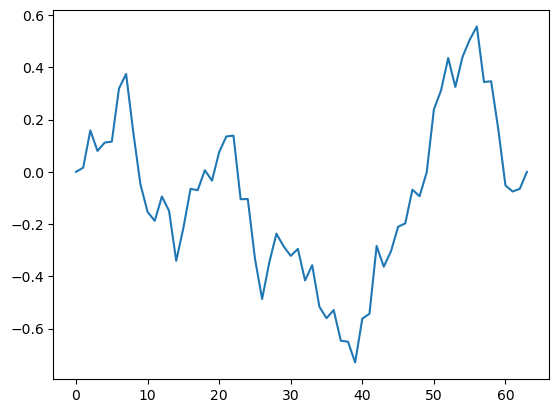

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import dblquad
from numpy import pi, sqrt, log




def get_tau_pairs(bridges, t_grid):
    def extract_tau_minus_plus(path, t_grid):
        mid = 0.5
        sign_changes = np.where(np.diff(np.sign(path)))[0]
        zero_times = [t_grid[i] for i in sign_changes]

        tau_minus = max([t for t in zero_times if t < mid], default=None)
        tau_plus  = min([t for t in zero_times if t > mid], default=None)

        return tau_minus, tau_plus
    
    taus = []
    for path in bridges:
        tau_minus, tau_plus = extract_tau_minus_plus(path, t_grid)
        if tau_minus is not None and tau_plus is not None and tau_minus < tau_plus:
            taus.append([tau_minus, tau_plus])
    return np.array(taus)


def theoretical_density(tau_minus, tau_plus):
    if 0 < tau_minus < tau_plus < 1:
        denom = 2 * pi * sqrt(tau_minus * (1 - tau_plus) * (tau_plus - tau_minus)**3)
        return 1.0 / denom
    return 0.0


# === STEP 4: Estimate empirical density using KDE ===
def compute_kde_density(tau_samples):
    kde = gaussian_kde(tau_samples.T, bw_method='scott')
    return kde


# === STEP 5: KL divergence ===
def kl_divergence(emp_kde, bounds=(0.01, 0.49, 0.51, 0.99), resolution=100):

    def integrand(tau_plus, tau_minus):
        p = emp_kde([tau_minus, tau_plus])[0]
        q = theoretical_density(tau_minus, tau_plus)
        if p > 0 and q > 0:
            return p * log(p / q)
        return 0.0

    a, b, c, d = bounds  # tau_minus in [a, b], tau_plus in [c, d]
    result, _ = dblquad(integrand, a, b, lambda _: c, lambda _: d)
    return result


# === MAIN EVALUATION FUNCTION ===
def evaluate_kl(bridges, t_grid):
    taus = get_tau_pairs(bridges, t_grid)
    emp_kde = compute_kde_density(taus)
    kl = kl_divergence(emp_kde)
    return kl


# Example dummy Brownian bridge generator
def sample_brownian_bridges(n_samples, n_steps):
    t = np.linspace(0, 1, n_steps)
    dt = 1.0 / (n_steps - 1)
    bridges = []
    for _ in range(n_samples):
        W = np.cumsum(np.random.randn(n_steps) * np.sqrt(dt))
        bridge = W - t * W[-1]  # Brownian bridge from 0 to 0
        bridges.append(bridge)
    return np.array(bridges), t

# Generate example data
bridges, t_grid = sample_brownian_bridges(n_samples=1000, n_steps=100)

# Compute KL divergence
kl = evaluate_kl(bridges, t_grid)
print(f"KL divergence: {kl:.5f}")
